## Load and evaluate a single trained classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from os import path
import json
from loss_calibration.classifier import FeedforwardNN
from loss_calibration.toy_example import posterior_ratio
from loss_calibration.loss import BCELoss_weighted
import matplotlib as mpl
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load data

In [ ]:
costs = [5., 1.]
threshold = 2.0

In [ ]:
# load test data
n_samples = 5000
th_test = torch.load(path.join("./data/1d_classifier/", "th_test.pt"))
x_test = torch.load(path.join("./data/1d_classifier/", "x_test.pt"))
d_test = (th_test>threshold).float()
N_test = th_test.shape[0]
print("N_test = ", N_test)


n_train_samples  = 500000
th_train = torch.load(path.join("./data/1d_classifier/", "th_train.pt"))[:n_train_samples]
x_train = torch.load(path.join("./data/1d_classifier/", "x_train.pt"))[:n_train_samples]
d_train = (th_train>threshold).float()
N_train = th_train.shape[0]
print("N_train", N_train)

N_test =  100000
N_train 500000


True ratios on training data

In [ ]:
bce_loss = BCELoss_weighted(costs, threshold)
ratios_train = torch.as_tensor([posterior_ratio(x) for x in x_train]).unsqueeze(1)

KeyboardInterrupt: 

Load classifier

In [ ]:
ckp = torch.load("./results/1d_classifier/test_model/best_model.pt", map_location=device)
#metadata = json.load(open("./results/1d_classifier/test_model/metadata.json"))
#metadata

In [ ]:
#clf = FeedforwardNN(1, list(map(int, metadata['architecture'].split("-")))[1:-1], 1)
clf = FeedforwardNN(1, [100,100,100], 1)
clf.load_state_dict(ckp["state_dict"])

<All keys matched successfully>

Text(0, 0.5, 'mean BCE loss')

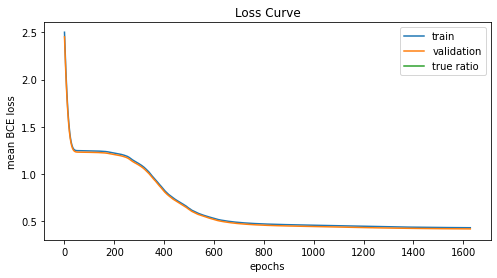

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(ckp['training_losses'], label='train')
ax.plot(ckp['validation_losses'], label='validation')
ax.axhline(bce_loss(ratios_train, d_train, th_train).mean(dim=0), c='g', label='true ratio')
ax.set_title('Loss Curve')
ax.ticklabel_format(style='sci',scilimits=(-3,4))
ax.legend()
ax.set_xlabel('epochs'); ax.set_ylabel('mean BCE loss')

In [ ]:
# BCE loss of true ratios
bce_loss(ratios_train, d_train, th_train).mean(dim=0).item()

tensor([0.4092])

In [ ]:
# BCE loss of trained classifier
bce_loss(clf(x_train), d_train, th_train).mean().item()

tensor(0.4153, grad_fn=<MeanBackward0>)

Make predictions

In [ ]:
true_ratios = torch.as_tensor([posterior_ratio(x) for x in x_test])

In [ ]:
predicted_ratios = clf(x_test)

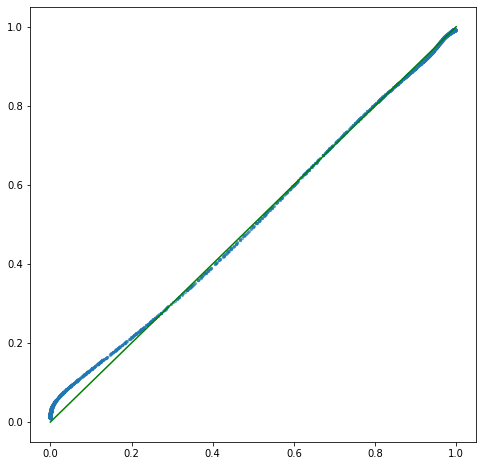

In [ ]:
sorted_idx = torch.argsort(true_ratios)
n_samples = 5000

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot([0,1], [0,1], c='g')
#ax.plot(true_ratios.numpy()[sorted_idx], predicted_ratios.detach().numpy()[sorted_idx])
ax.scatter(true_ratios.numpy()[:n_samples], predicted_ratios.detach().numpy()[:n_samples], alpha=0.5, s=5)

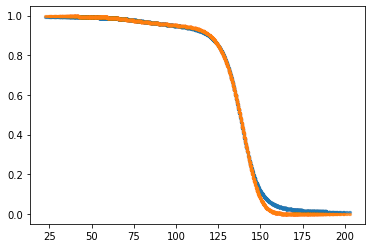

In [ ]:
sorted_idx = torch.argsort(true_ratios)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x_test.numpy()[:n_samples], predicted_ratios.detach().numpy()[:n_samples], alpha=0.5, s=5)
ax.scatter(x_test[:n_samples], true_ratios[:n_samples], alpha=0.5, s=5)